This notebook picks up where the other left off, because it's on a local workstation with PyPlot.

In [5]:
using PyPlot
plt[:style][:use]("ggplot")

In [4]:
exp_params = Dict()
dir = joinpath(homedir(), "seungmount/research/Alembic/datasets/davit_piritest")
exp_dirs = ["standard_224", "standard_160", "across_224", "across_160"]
ms_names = ["original", "net_adj", "net_across", "bandpass"]
for exp in exp_dirs
    exp_params[exp] = Dict()
    for ms in ms_names
        fn = join([exp, ms], "_")
        exp_params[exp][ms] = readdlm(joinpath(homedir(), dir, string(fn, "_params.csv")))
    end
end

        filtered = ones(m)
        filtered[collect(get_rejected_indices(match))] = 0
        dist = get_properties(match, "norm")
        r_max = get_properties(match, "r_max")
        sigma = get_properties(match, 0.75)
        r_delta = get_properties(match, 10)
        params = hcat(filtered, dist, r_max, sigma, r_delta)

In [17]:
param_names = Dict(1 => "filtered", 2 => "distance", 3 => "r_max", 4 => "sigma", 5 => "r_delta")

Dict{Int64,String} with 5 entries:
  4 => "sigma"
  2 => "distance"
  3 => "r_max"
  5 => "r_delta"
  1 => "filtered"

In [7]:
standard_224 = exp_params["standard_224"]

Dict{Any,Any} with 4 entries:
  "bandpass"   => [1.0 16.543 … 2.42008 0.156665; 1.0 16.5923 … 2.46526 0.23957…
  "original"   => [1.0 16.5949 … 3.30224 0.157133; 1.0 16.6178 … 3.32499 0.2563…
  "net_adj"    => [1.0 17.1376 … 7.1877 0.435392; 1.0 17.1393 … 7.52087 0.56422…
  "net_across" => [1.0 16.6307 … 6.39829 0.399027; 1.0 17.1251 … 6.63302 0.5563…

In [93]:
function plot_meshset_hist(ms_params, total_ms, k)
    axes = []
    for i in 1:4
        subplot(4, total_ms, 4*(k-1)+i)
        binmax = maximum(ms_params[:,i+1])
        bins = collect(linspace(0,binmax,50))
        plt[:hist](ms_params[ms_params[:,1] .== 1, i+1], bins=bins, color="g", alpha=0.3)
        plt[:hist](ms_params[ms_params[:,1] .== 0, i+1], bins=bins, color="r", alpha=0.3)
        ax = gca()
        ax[:set_ylim]((0.1,10e5))
        ax[:set_yscale]("log")
        push!(axes, ax)
    end
    return axes
end

plot_meshset_hist (generic function with 2 methods)

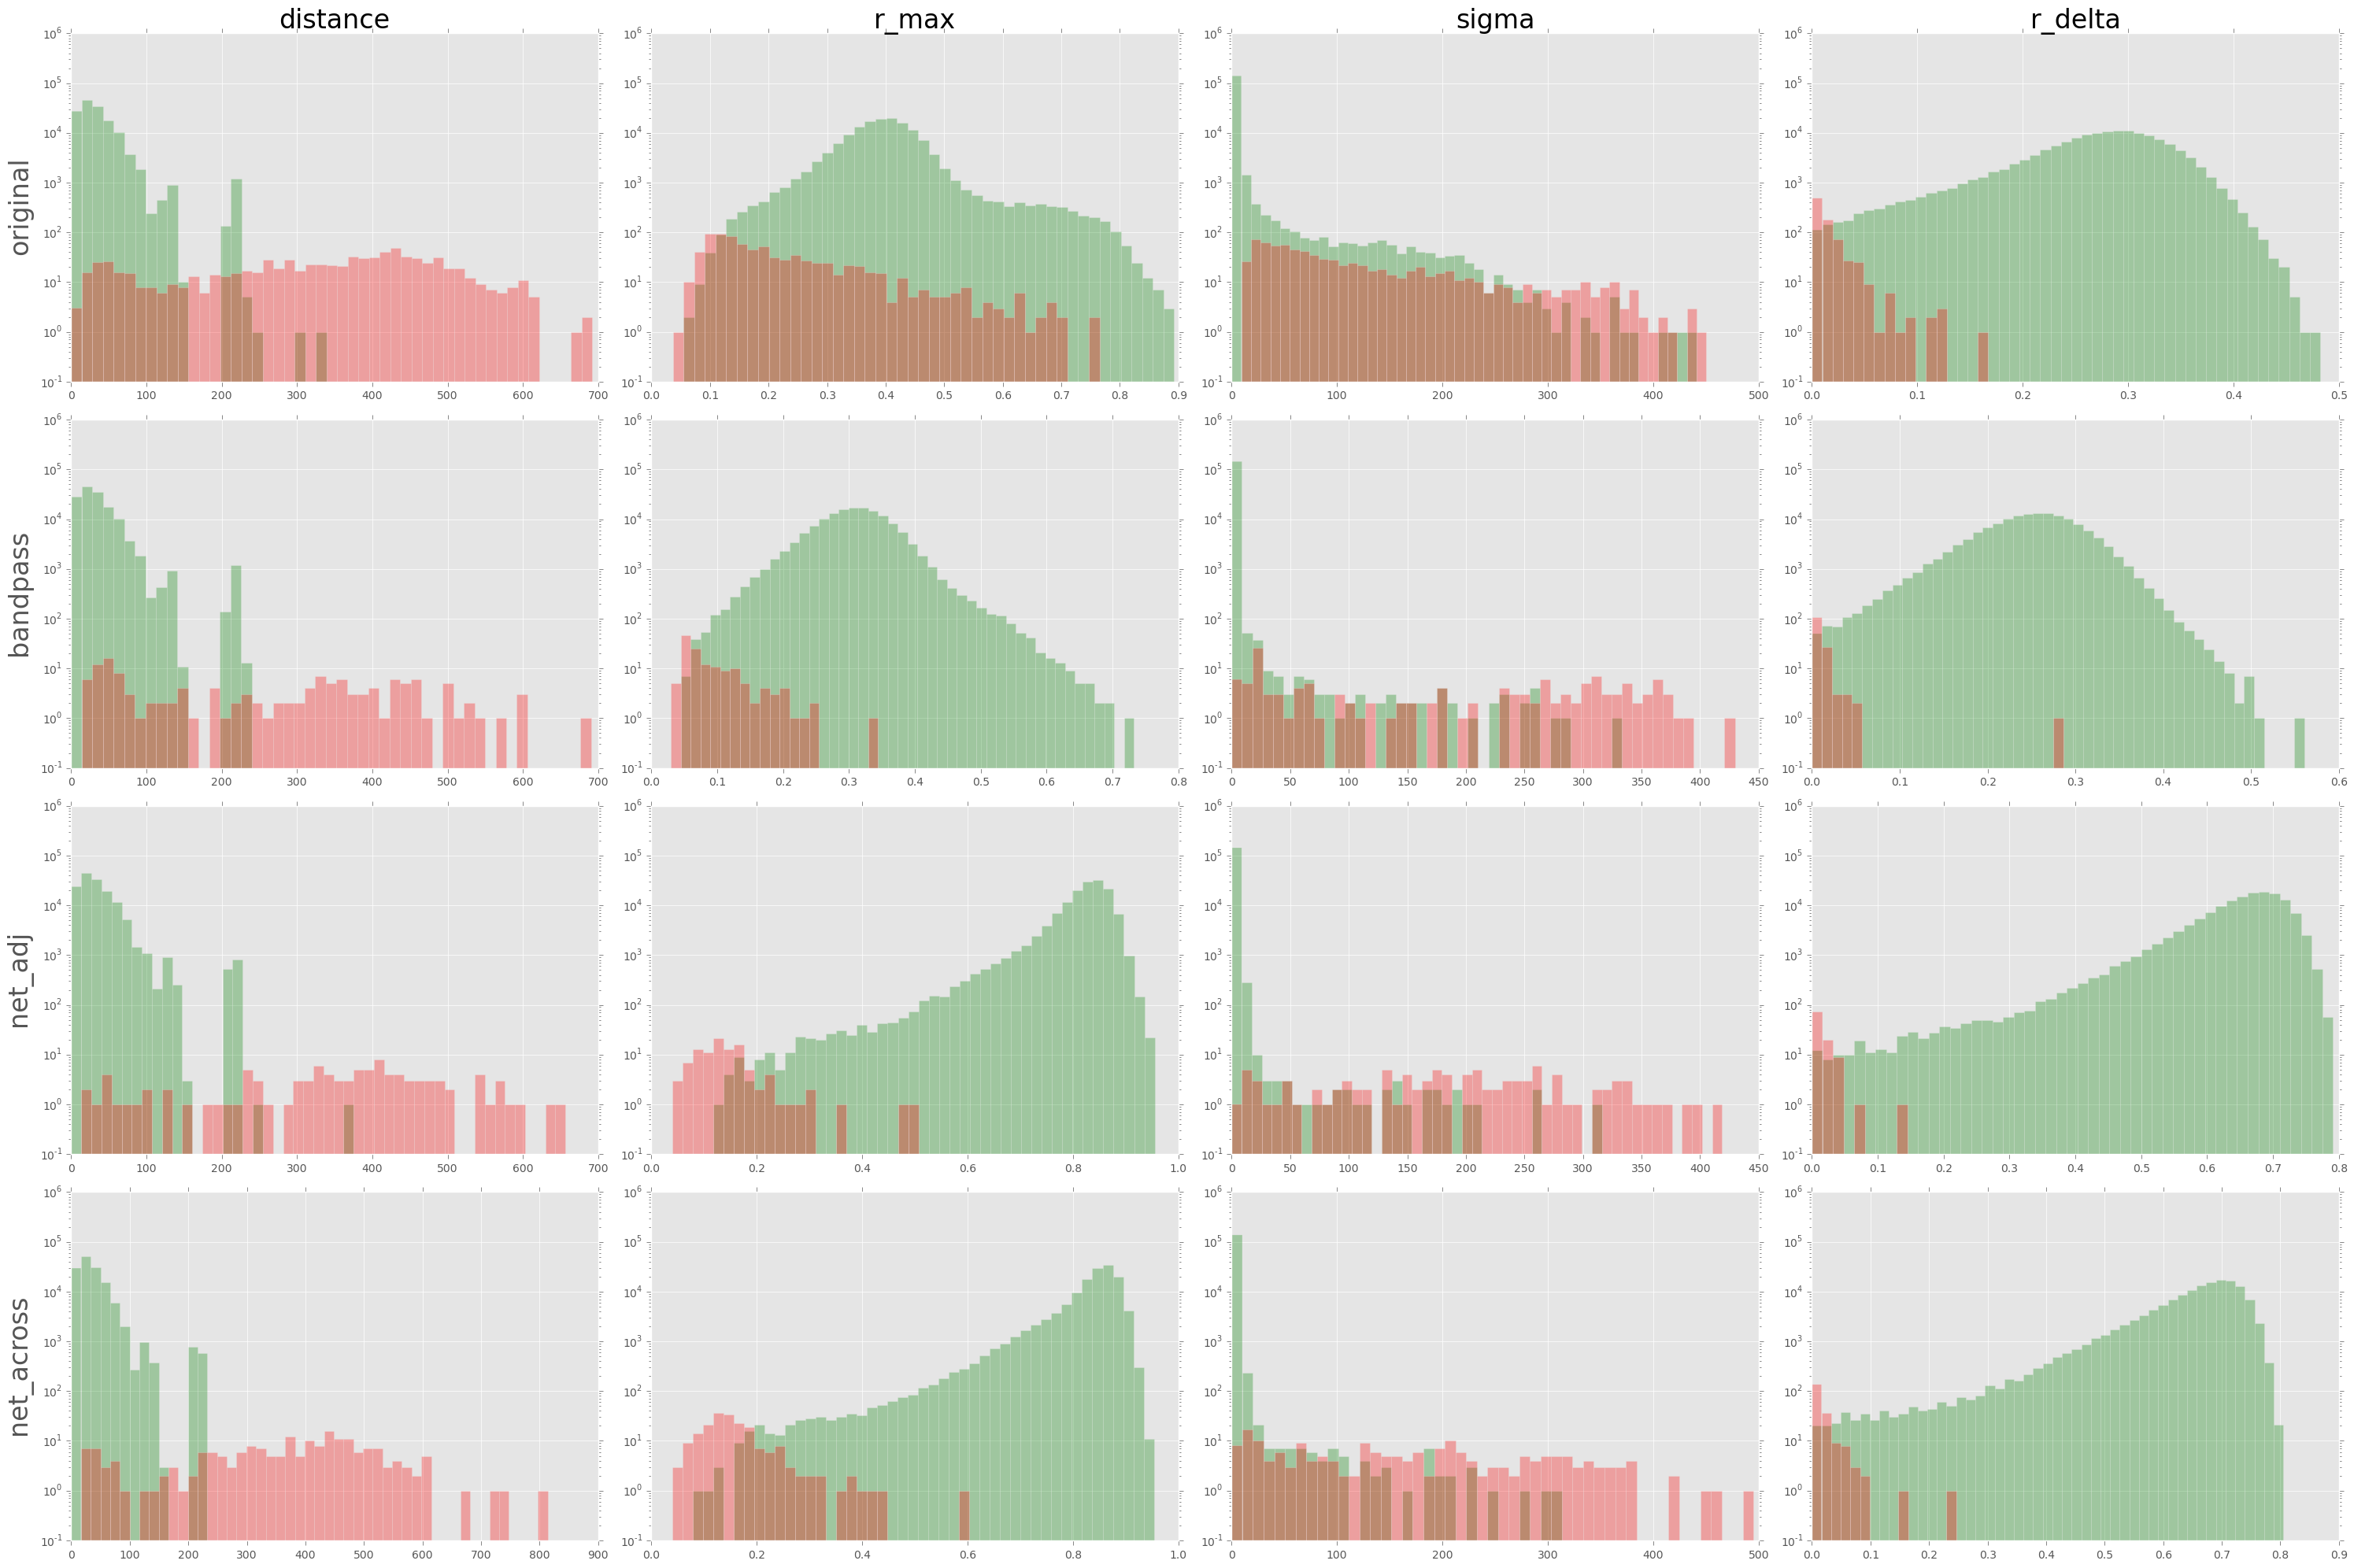

In [94]:
fig = figure(figsize=(30,20))
# fig, axes = plt[:subplots](nrows=4, ncols=4, figsize=(30,20))
rows = ["original", "bandpass", "net_adj", "net_across"]
cols = ["distance", "r_max", "sigma", "r_delta"]
axes = Array{PyCall.PyObject,2}(length(rows),length(cols))
for (k, ms_name) in enumerate(rows)
    ms_params = standard_224[ms_name]
    axes[k,:] = plot_meshset_hist(ms_params, 4, k)
end

for (ax, col) in zip(axes[1,:], cols)
    ax[:set_title](col, fontsize=24)
end
for (ax, row) in zip(axes[:,1], rows)
    ax[:set_ylabel](row, fontsize=24)
end
fig[:tight_layout]()
plt[:show]()

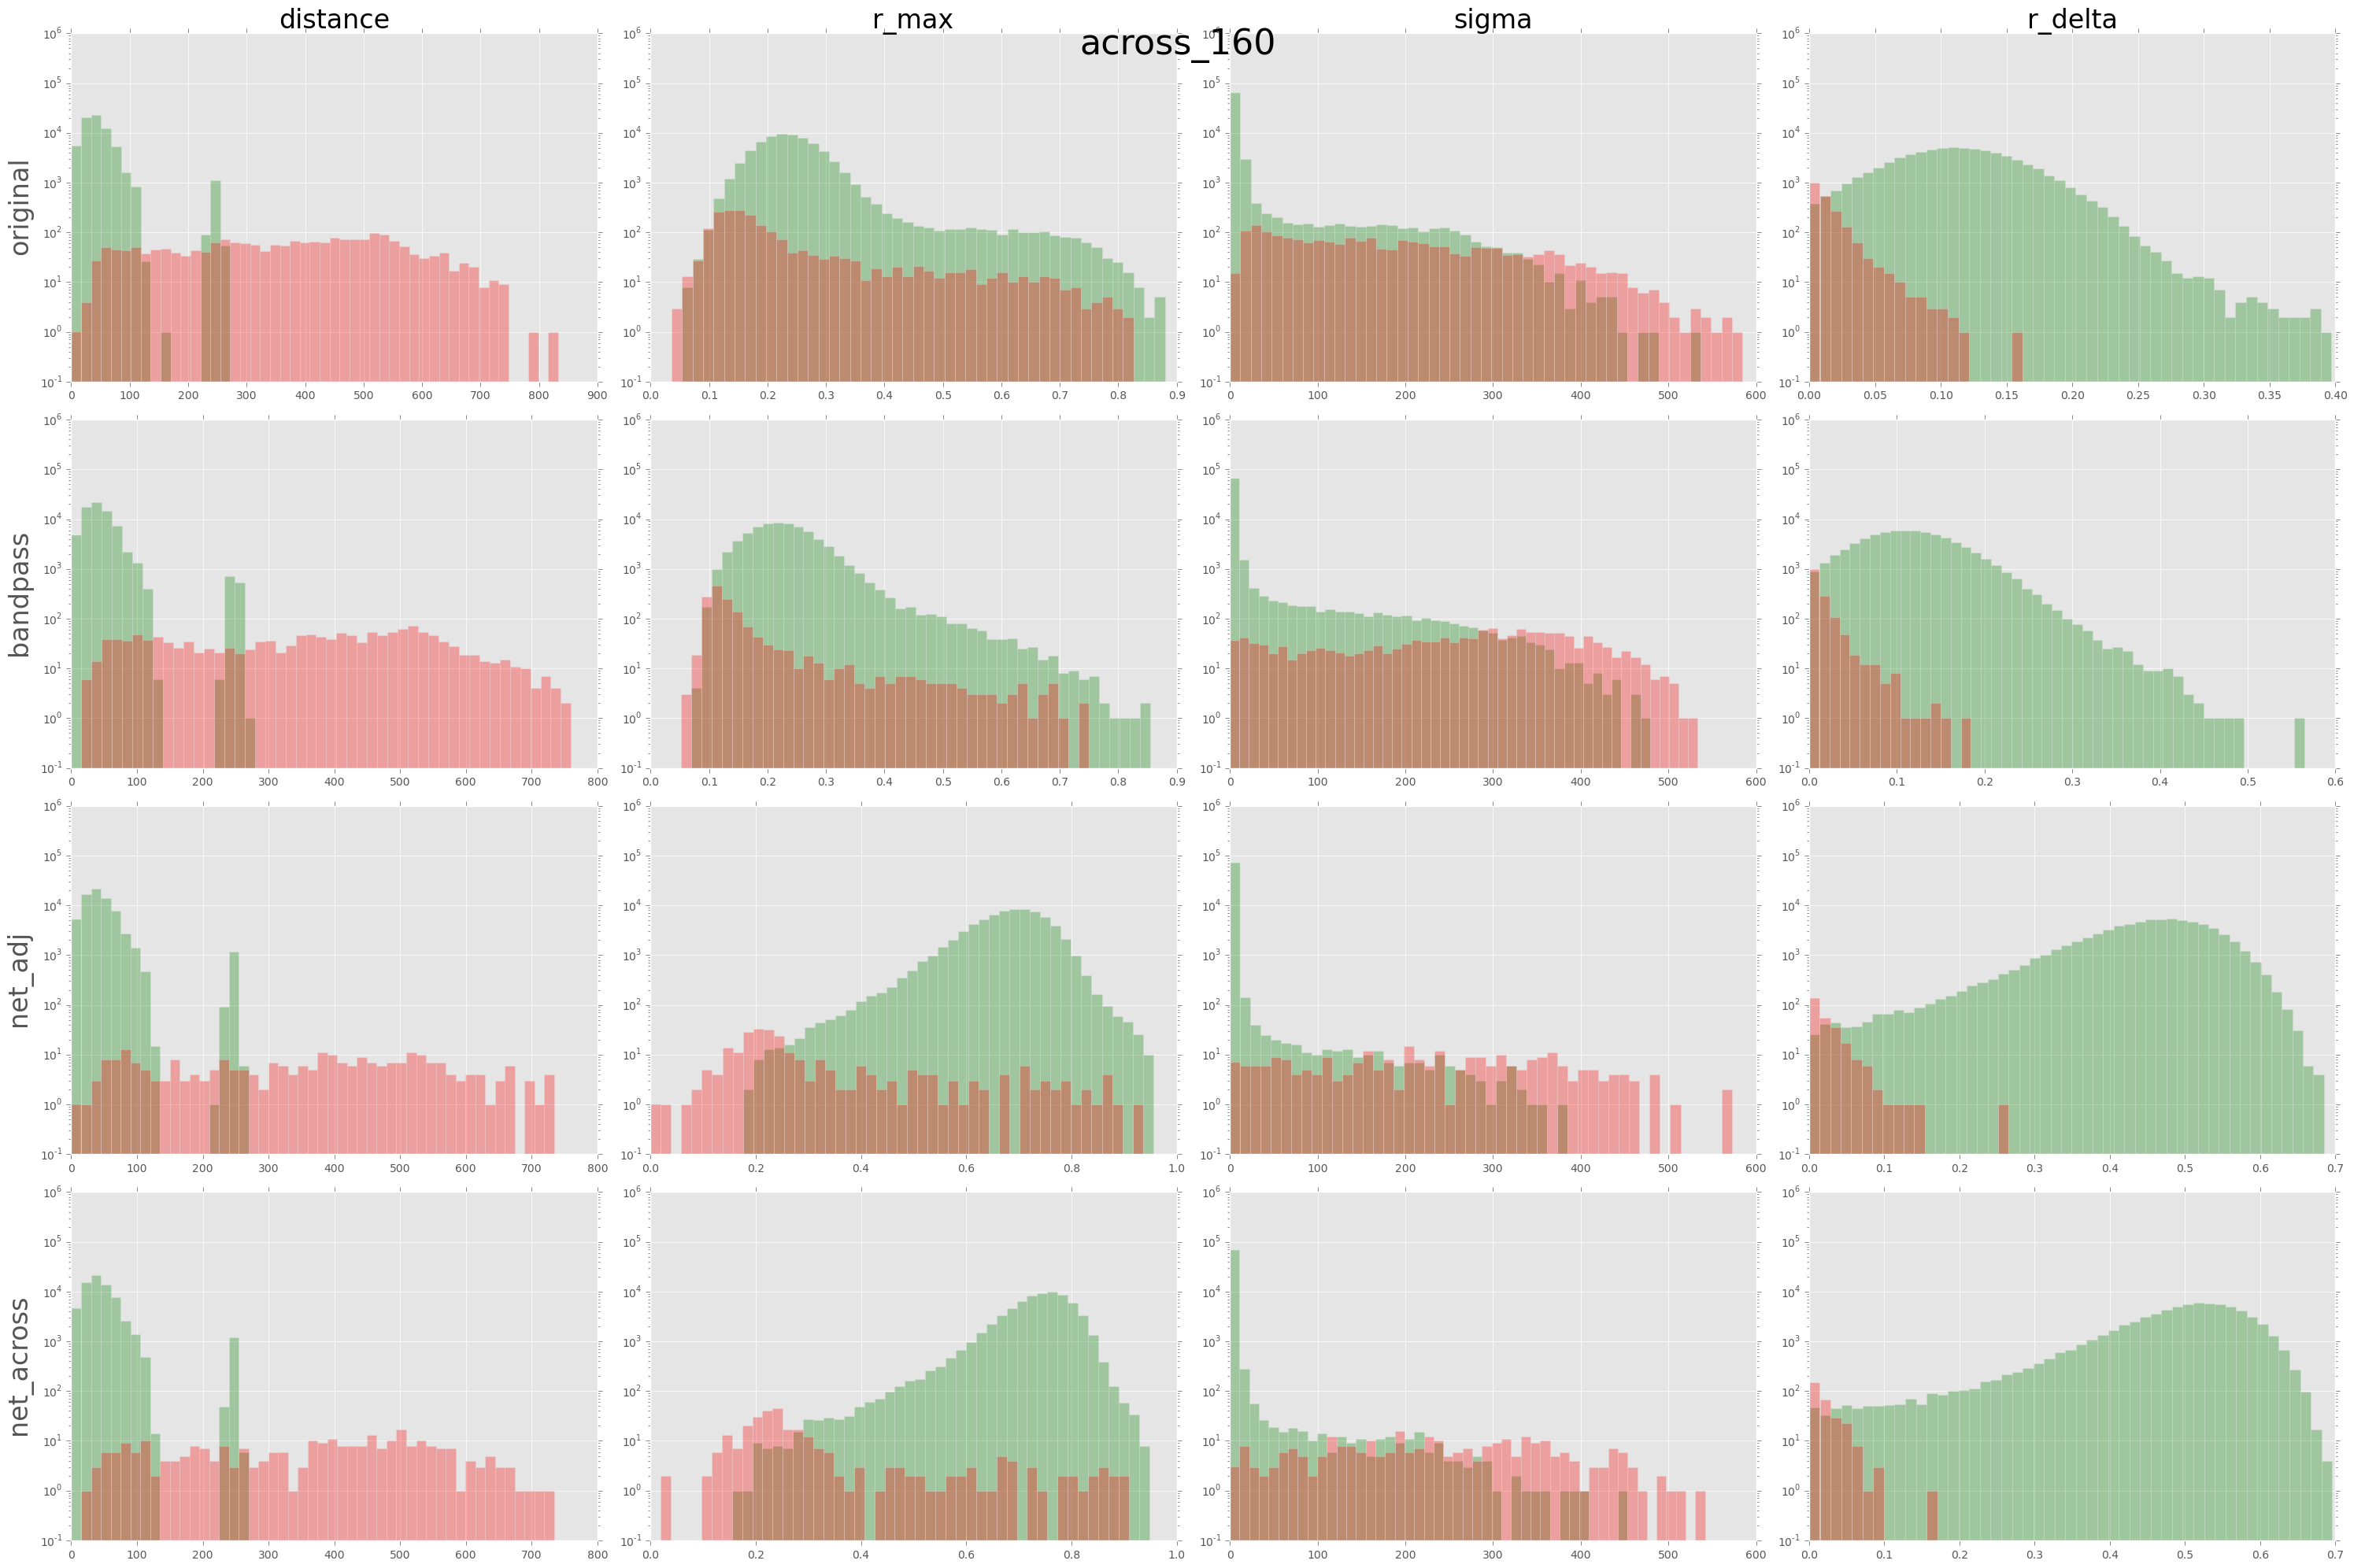

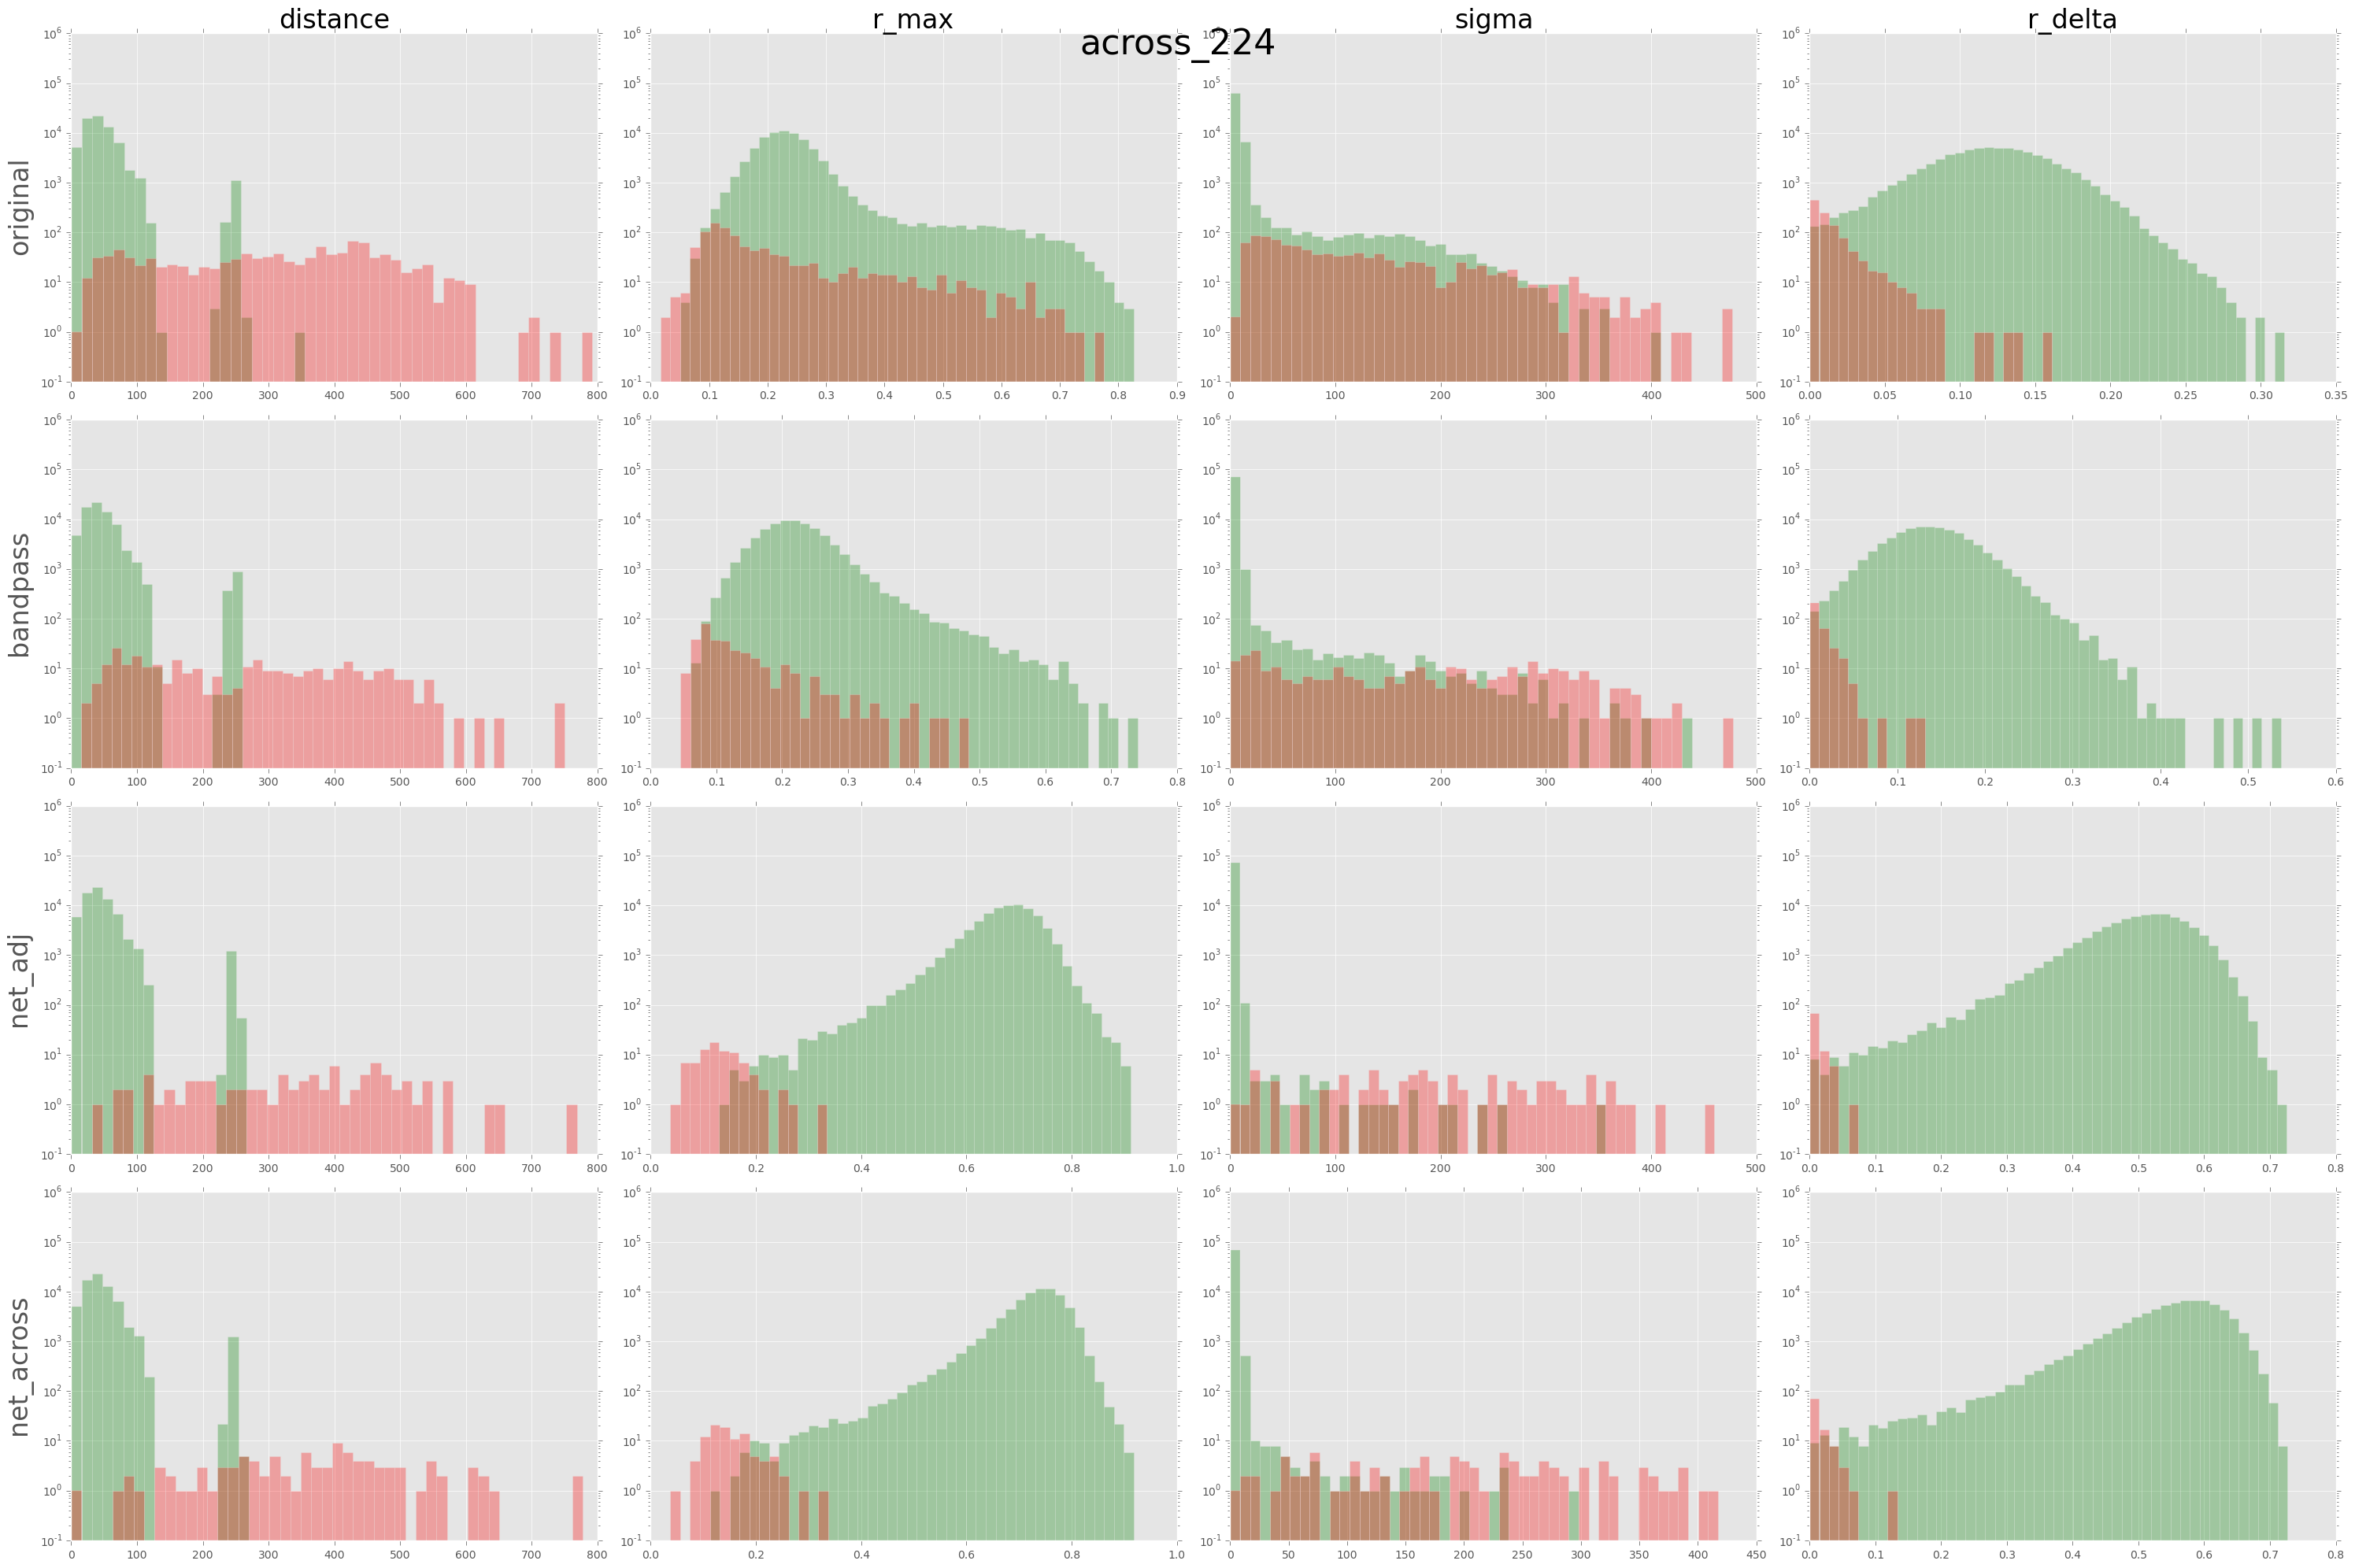

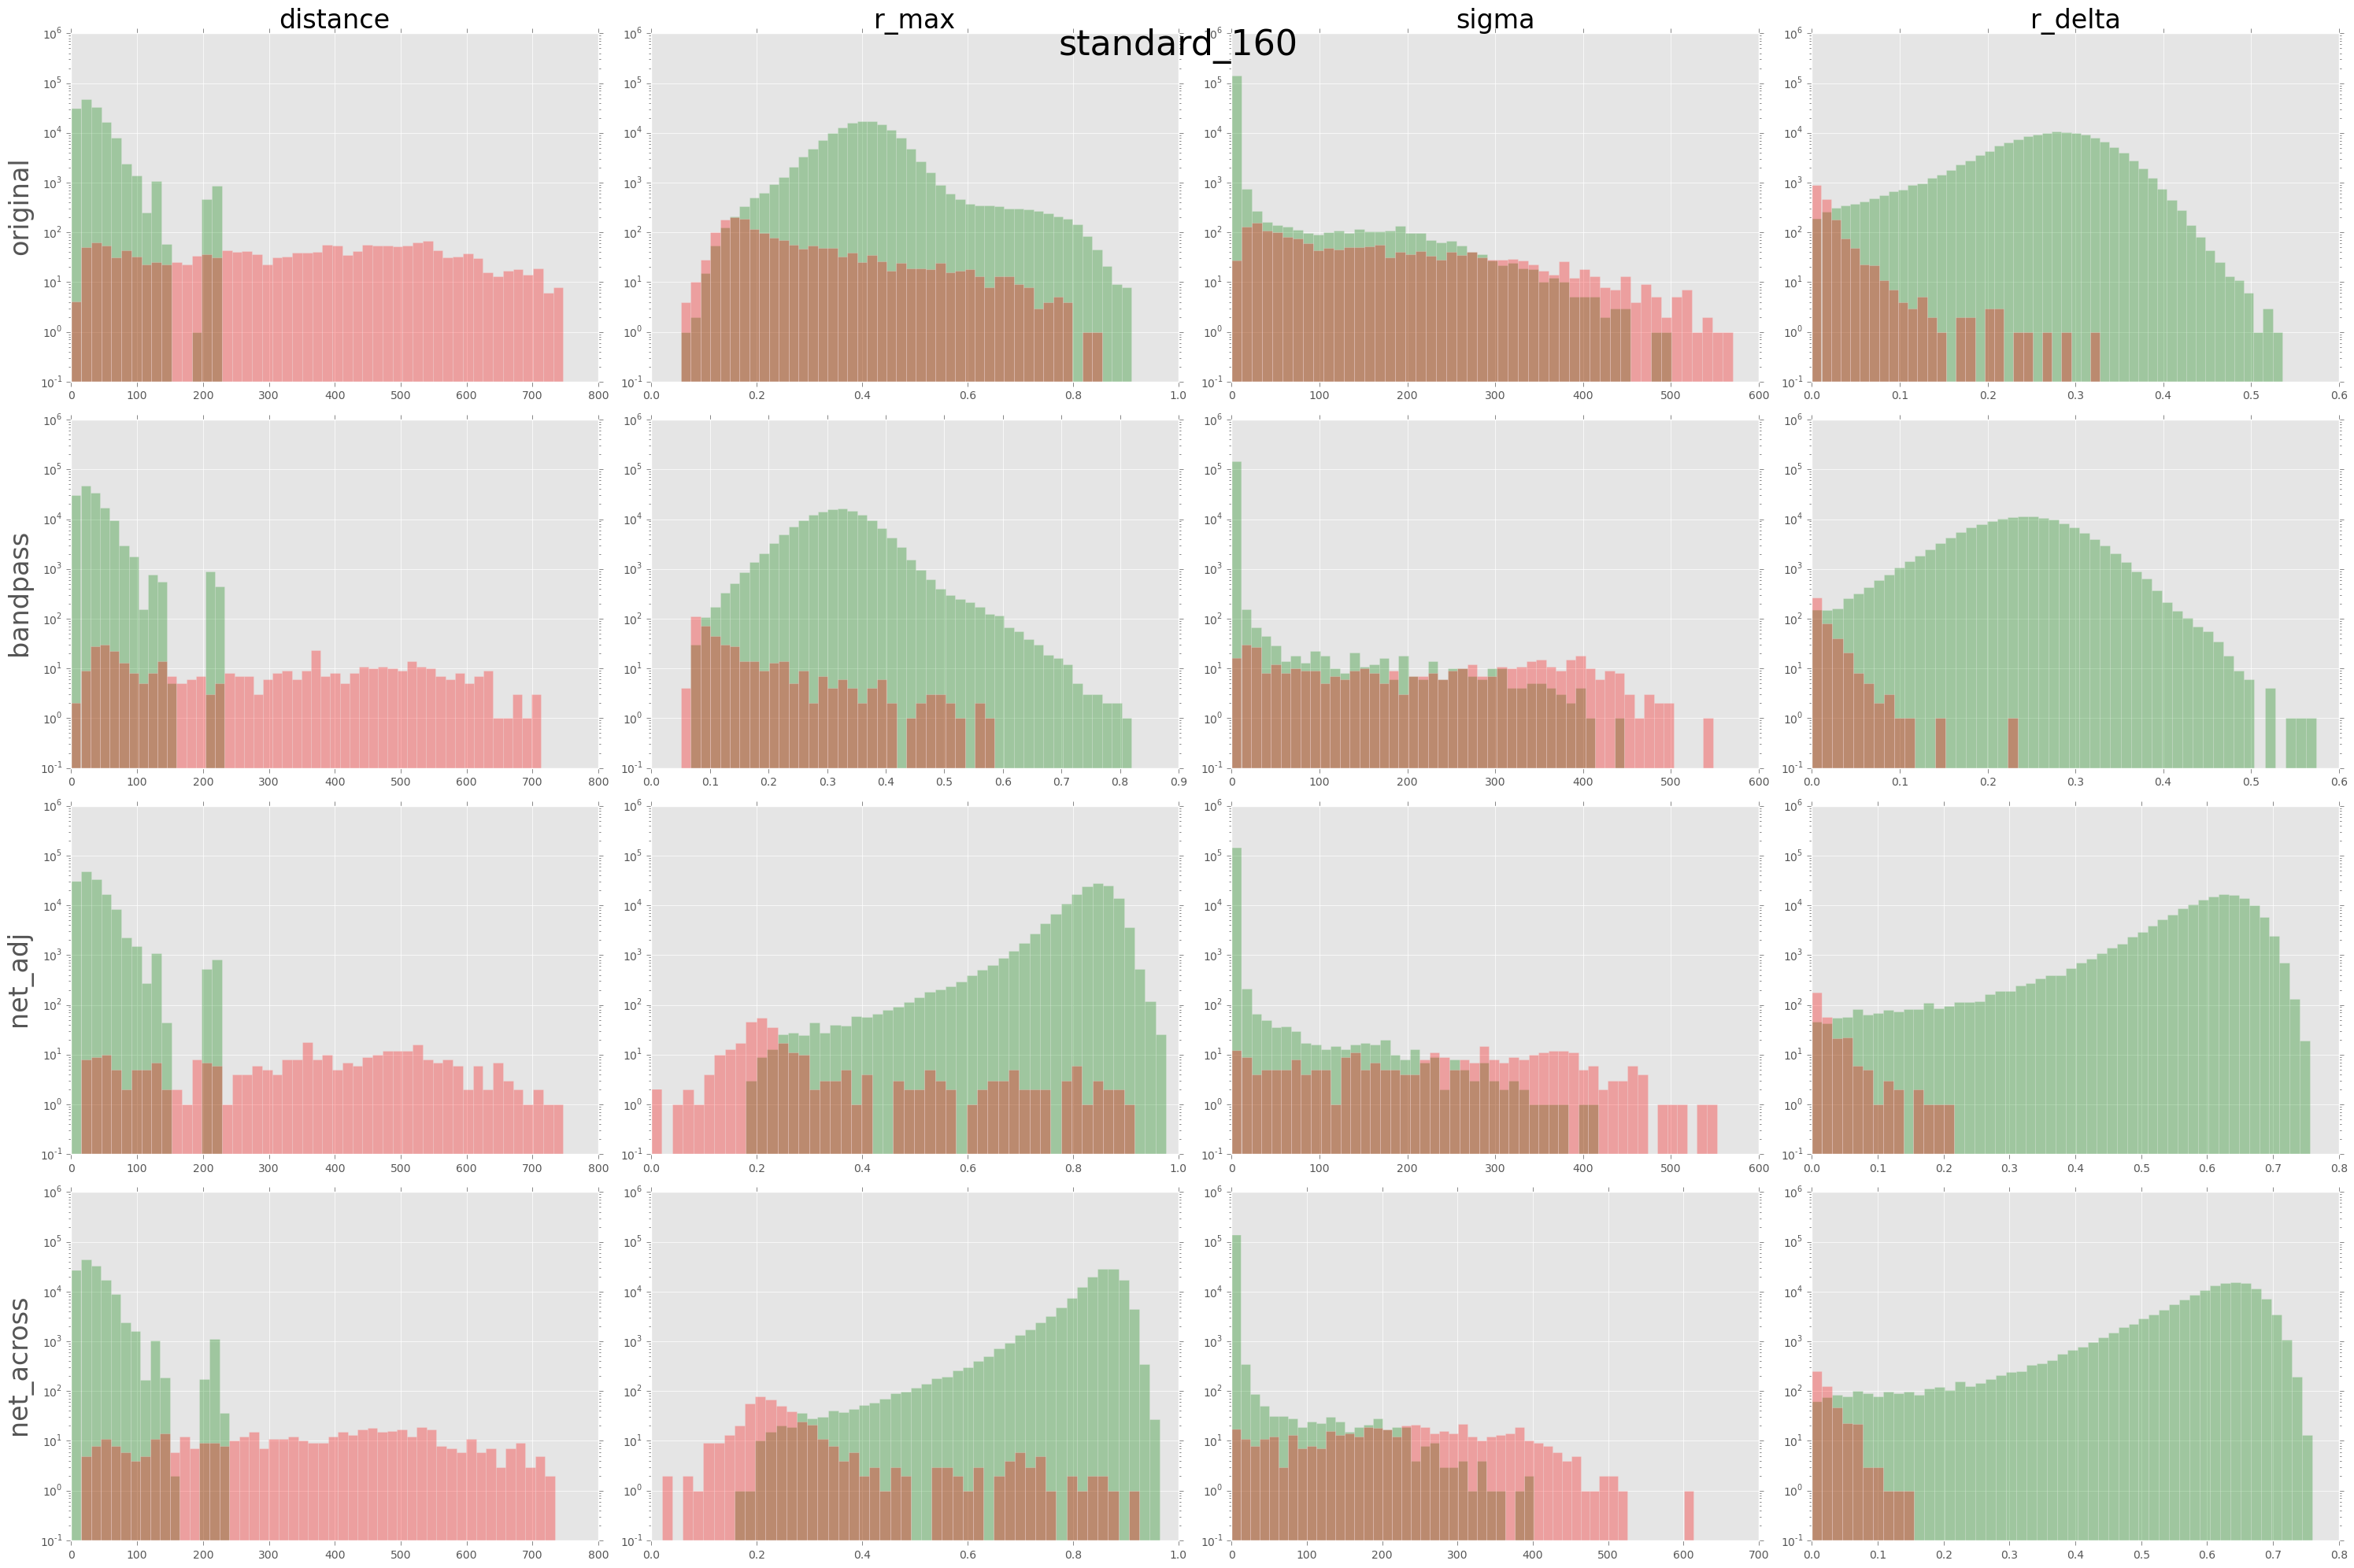

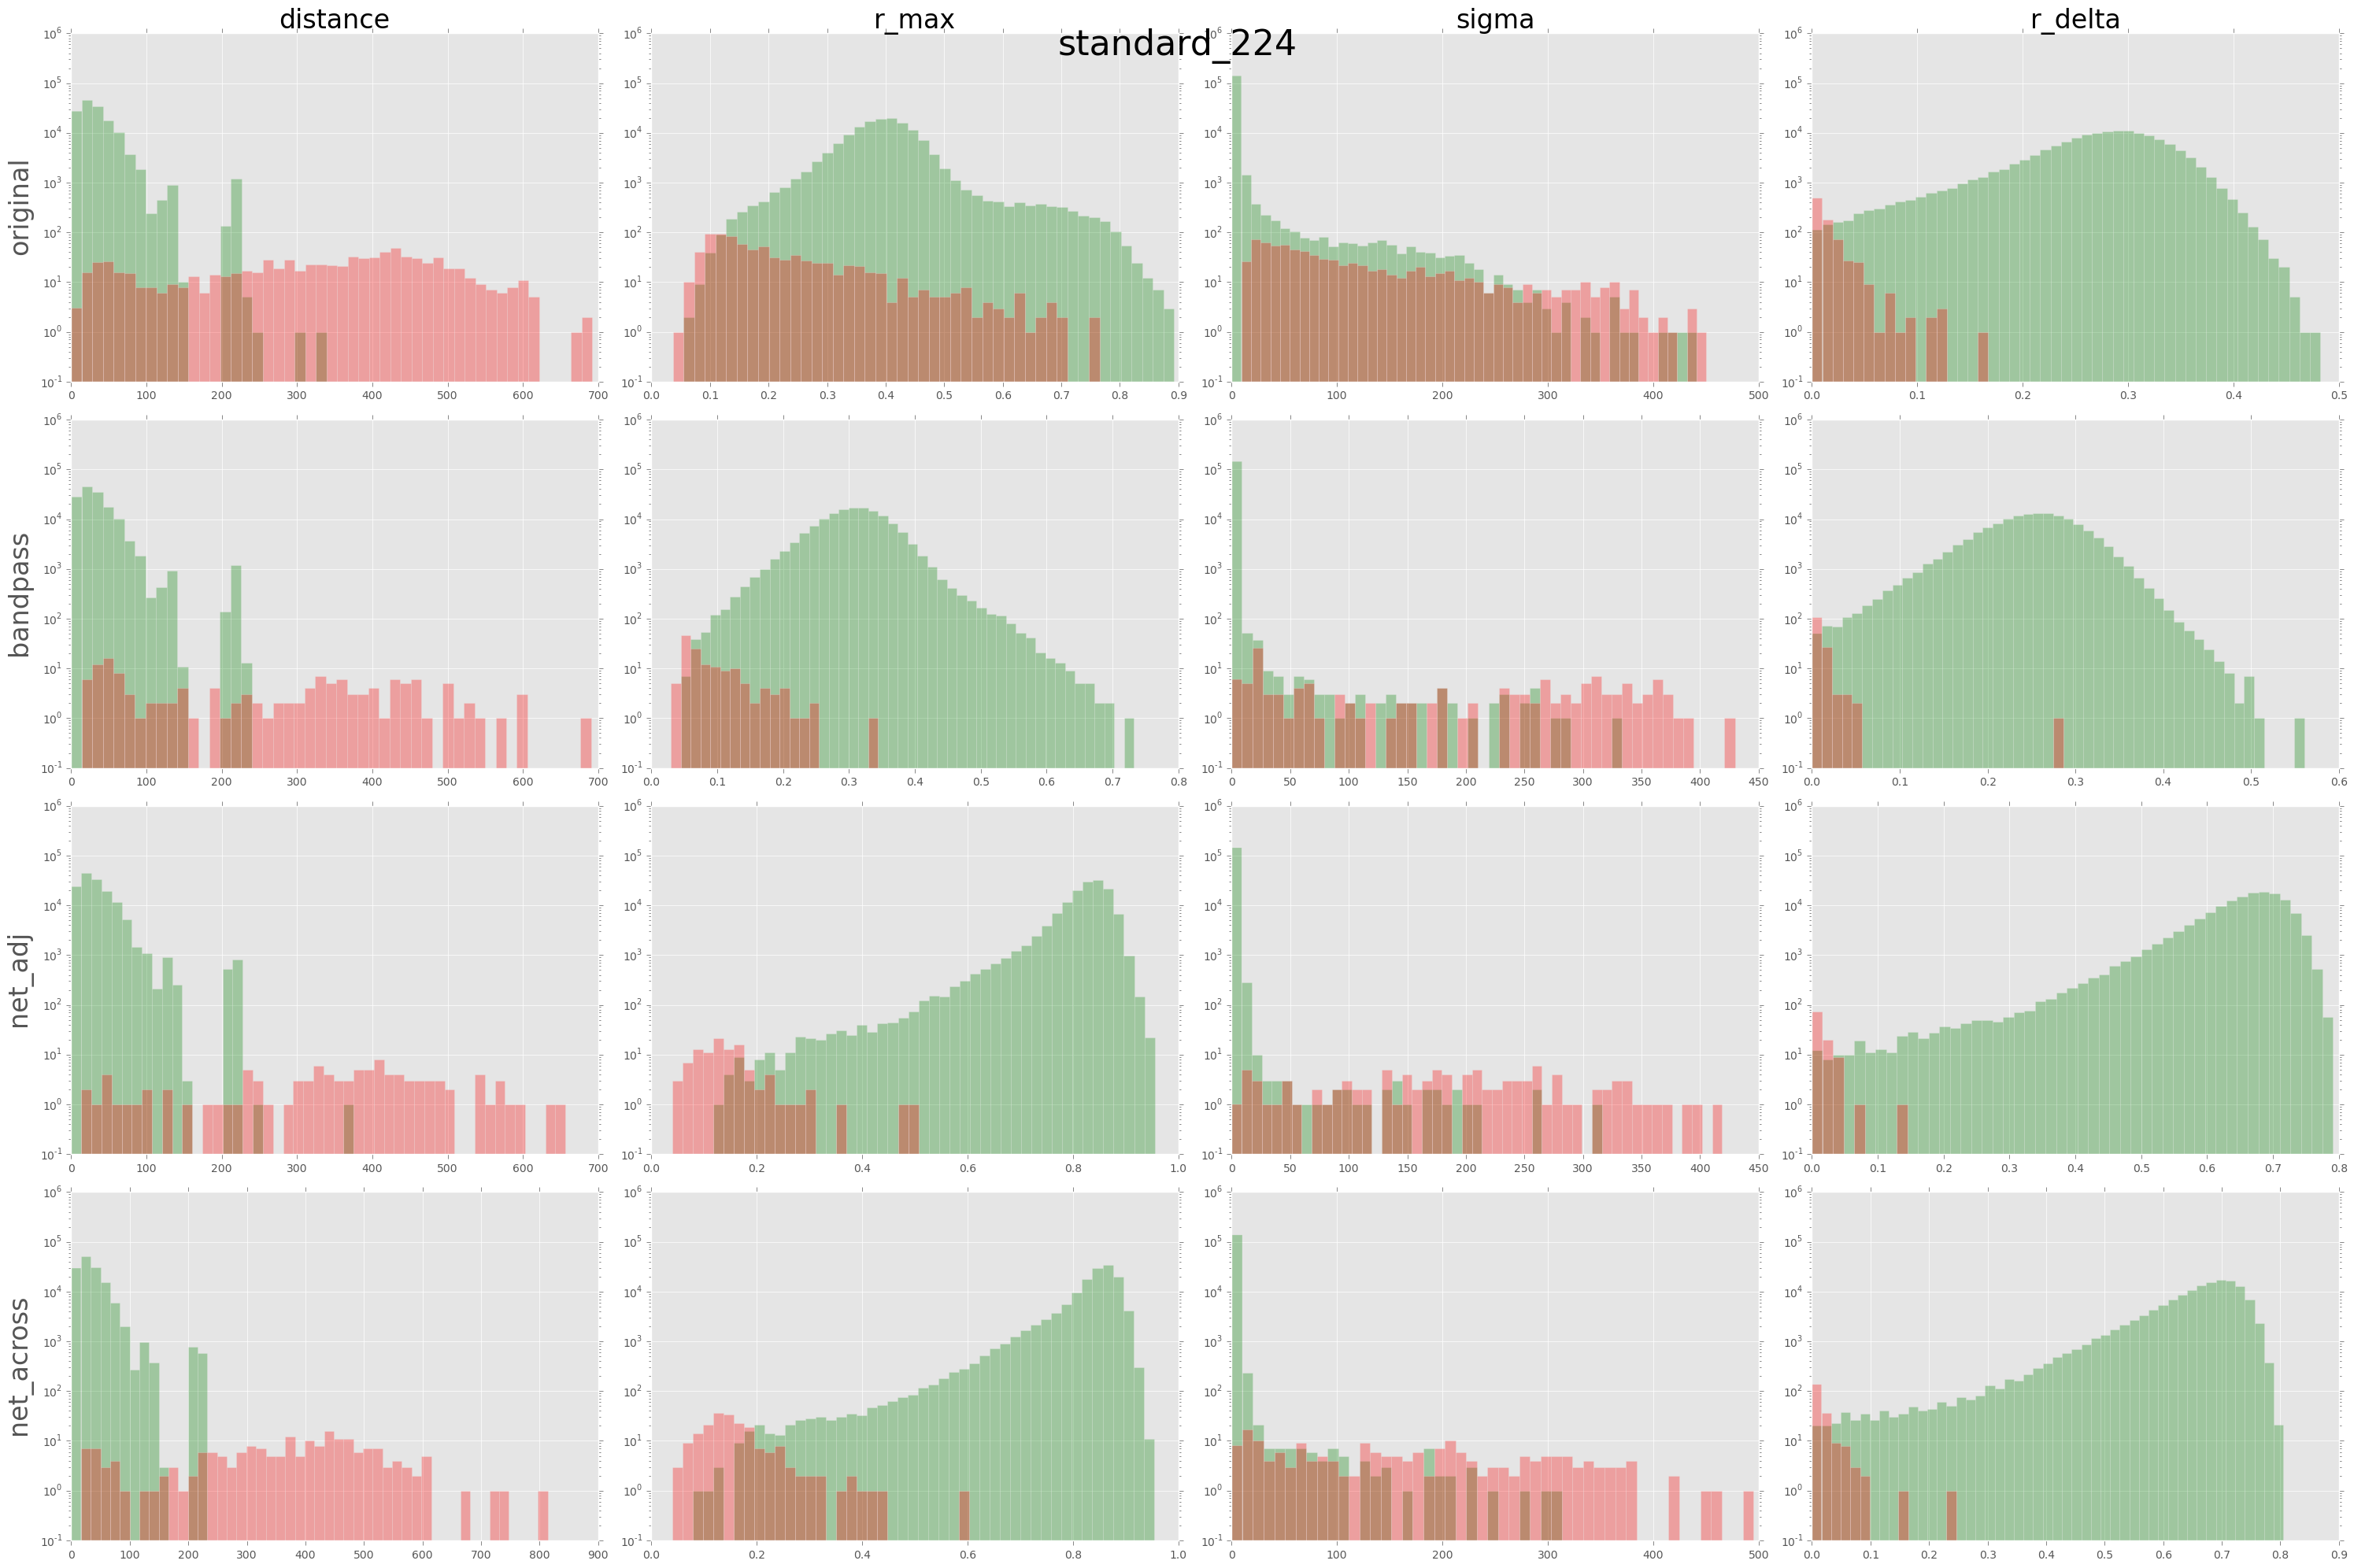

In [221]:
for (exp_name, param_dict) in exp_params
    fig = figure(figsize=(30,20))
    # fig, axes = plt[:subplots](nrows=4, ncols=4, figsize=(30,20))
    rows = ["original", "bandpass", "net_adj", "net_across"]
    cols = ["distance", "r_max", "sigma", "r_delta"]
    axes = Array{PyCall.PyObject,2}(length(rows),length(cols))
    for (k, ms_name) in enumerate(rows)
        ms_params = param_dict[ms_name]
        axes[k,:] = plot_meshset_hist(ms_params, 4, k)
    end

    for (ax, col) in zip(axes[1,:], cols)
        ax[:set_title](col, fontsize=24)
    end
    for (ax, row) in zip(axes[:,1], rows)
        ax[:set_ylabel](row, fontsize=24)
    end
    suptitle(exp_name, fontsize=32)
    fig[:tight_layout]()
    plt[:show]()
end

In [145]:
"""
Compile precision & recall on param data

f: binary array of labels
d: data array
x: range of thresholds to plot p&r against
"""
function compile_precision_recall(f, d, x)
    n = length(f)
    tp = zeros(Int64, length(x))
    fn = zeros(Int64, length(x))
    fp = zeros(Int64, length(x))
    for (k,z) in enumerate(x)
        tp[k] = sum(f[d .> z] .== 1)
        fp[k] = sum(f[d .> z] .== 0)
        fn[k] = sum(f[d .<= z] .== 1)
    end
    precision = tp ./ (tp + fp)
    recall = tp ./ (tp + fn)
    f1 = 2*tp ./ (2*tp + fp + fn)
    return precision, recall, f1
end        

compile_precision_recall

In [176]:
"""
Compile tp, fp, fn, tn

f: binary array of labels
d: data array
x: range of thresholds to plot p&r against
"""
function compile_rejection_accuracy(f, d, x)
    n = length(f)
    tp = zeros(Int64, length(x))
    fn = zeros(Int64, length(x))
    fp = zeros(Int64, length(x))
    tn = zeros(Int64, length(x))
    for (k,z) in enumerate(x)
        tp[k] = sum(f[d .> z] .== 1)
        fp[k] = sum(f[d .> z] .== 0)
        fn[k] = sum(f[d .<= z] .== 1)
        tn[k] = sum(f[d .<= z] .== 0)
    end
    return tp, fp, fn, tn
end  

compile_rejection_accuracy

In [146]:
x = collect(linspace(0,1,300))
nar_f = standard_224["net_adj"][:,1]
nar_d = standard_224["net_adj"][:,8]
bpr_f = standard_224["bandpass"][:,1]
bpr_d = standard_224["bandpass"][:,8]
na_pr, na_re, na_f1 = compile_precision_recall(nar_f, nar_d, x)
bp_pr, bp_re, bp_f1 = compile_precision_recall(bpr_f, bpr_d, x);

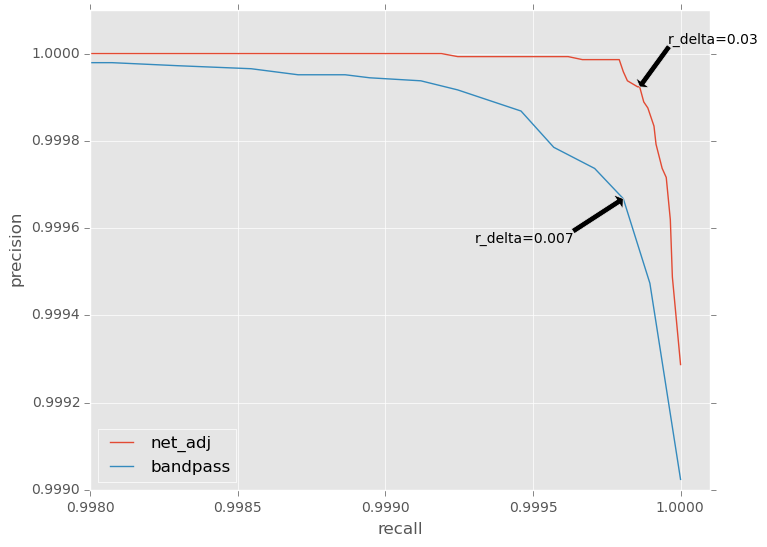

In [170]:
k = 80
plot(na_re[1:k], na_pr[1:k], label="net_adj")
plot(bp_re[1:k], bp_pr[1:k], label="bandpass")
ax = gca()
ax[:set_ylim]((0.9990,1.0001))
ax[:set_xlim]((0.998,1.0001))
xlabel("recall")
ylabel("precision")
legend(loc="best");
annotate("r_delta=$(round(x[na_f1 .== maximum(na_f1)][1],3))",
    xy=[na_re[na_f1 .== maximum(na_f1)];na_pr[na_f1 .== maximum(na_f1)]],
    xytext=[na_re[na_f1 .== maximum(na_f1)]+0.0001;na_pr[na_f1 .== maximum(na_f1)]+0.0001],
    xycoords="data",
    arrowprops=Dict("facecolor"=>"black"))
annotate("r_delta=$(round(x[bp_f1 .== maximum(bp_f1)][1],3))",
    xy=[bp_re[bp_f1 .== maximum(bp_f1)];bp_pr[bp_f1 .== maximum(bp_f1)]],
    xytext=[bp_re[bp_f1 .== maximum(bp_f1)]-0.0005;bp_pr[bp_f1 .== maximum(bp_f1)]-0.0001],
    xycoords="data",
    arrowprops=Dict("facecolor"=>"black"));

In [148]:
x[na_f1 .== maximum(na_f1)]

1-element Array{Float64,1}:
 0.0301003

In [149]:
x[bp_f1 .== maximum(bp_f1)]

1-element Array{Float64,1}:
 0.00668896

In [172]:
a = standard_224["net_adj"][standard_224["net_adj"][:,5] .> 0.06,:]
a[a[:,1] .== 0, :]

2×5 Array{Float64,2}:
 0.0  25.9408  0.30813  14.4447  0.0715022
 0.0  43.8548  0.48442  13.3183  0.141803 

In [187]:
x = collect(linspace(0,1,300))
nar_f = standard_224["net_adj"][:,1]
nar_d = standard_224["net_adj"][:,5]
bpr_f = standard_224["bandpass"][:,1]
bpr_d = standard_224["bandpass"][:,5]
na_tp, na_fp, na_fn, na_tn = compile_rejection_accuracy(nar_f, nar_d, x)
bp_tp, bp_fp, bp_fn, bp_tn = compile_rejection_accuracy(bpr_f, bpr_d, x);

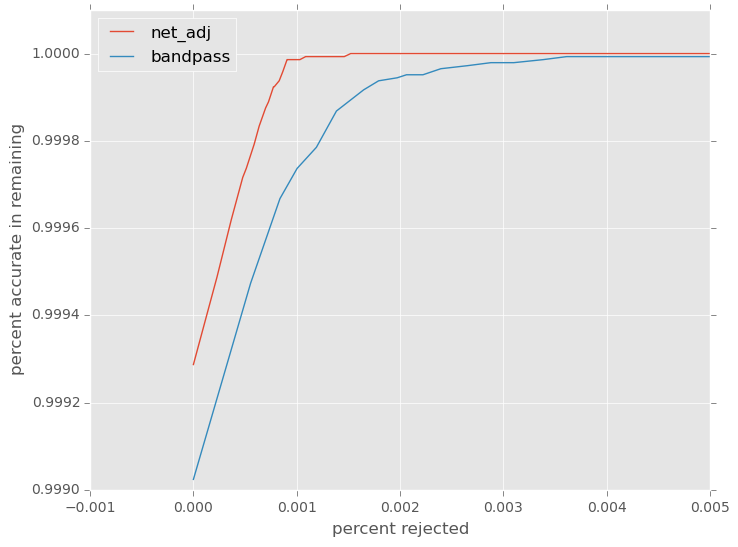

In [204]:
plot((na_fn + na_tn)/length(nar_f), na_tp ./ (na_fp + na_tp), label="net_adj")
plot((bp_fn + bp_tn)/length(bpr_f), bp_tp ./ (bp_fp + bp_tp), label="bandpass")
ax = gca()
xlabel("percent rejected")
ylabel("percent accurate in remaining")
ax[:set_xlim]((-0.001,0.005))
ax[:set_ylim]((0.9990,1.0001))
legend(loc="best");

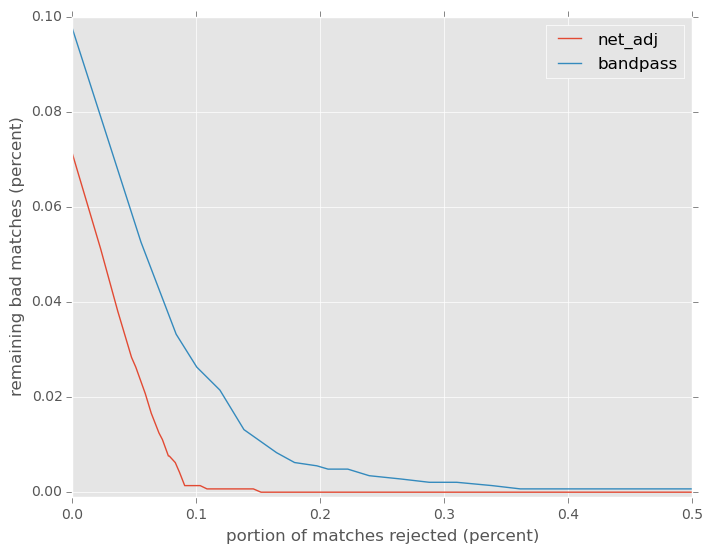

In [218]:
plot((na_fn + na_tn)/length(nar_f) * 100, (1 - na_tp ./ (na_fp + na_tp))*100, label="net_adj")
plot((bp_fn + bp_tn)/length(bpr_f) * 100, (1 - bp_tp ./ (bp_fp + bp_tp))*100, label="bandpass")
ax = gca()
xlabel("portion of matches rejected (percent)")
ylabel("remaining bad matches (percent)")
ax[:set_xlim]((0,0.5))
ax[:set_ylim]((-0.001,0.1))
legend(loc="best");